Importando los módulos necesarios

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib
from sklearn.feature_selection import RFECV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, \
    HalvingGridSearchCV
from sklearn.metrics import classification_report
import lightgbm
import numpy as np

Cargando el dataset y generando los conjuntos de entrenamiento y prueba

In [3]:
df = pd.read_csv("Dataset_ListoParaModelo.csv")
df.dropna(inplace=True)

X = df[df.columns.tolist()[:-1]]
y = df[df.columns.tolist()[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creando el modelo de Red Neuronal

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_dim=123, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        "accuracy"
    ]
)

model.summary()
model.fit(X_train, y_train, epochs=50)

y_pred_ann = model.predict(X_test).ravel()
fpr_ann, tpr_ann, _ann = metrics.roc_curve(y_test, y_pred_ann)
auc_ann = round(metrics.roc_auc_score(y_test, y_pred_ann), 4)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                7936      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,049
Trainable params: 10,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
442/442 [==============================] - 1s 2ms/step - loss: 0.7006 - accuracy: 0.5118
Epoch 2/50
442/442 [==============================] - 1s 2ms/step - loss: 0.6871 -

Creando el modelo de Bosques Aleatorios

In [22]:
rfc = RandomForestClassifier(bootstrap=False, min_samples_split=12, n_estimators=1200,
                             random_state=42)
rfc.fit(X_train.values, y_train.values)

y_pred_rf = rfc.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy: RFC", metrics.accuracy_score(y_test, y_pred_rf))
fpr_rf, tpr_rf, _rf = metrics.roc_curve(y_test, y_pred_rf)
auc_rf = round(metrics.roc_auc_score(y_test, y_pred_rf), 4)

C:\Users\Isaias Olmos\.conda\envs\Dota2Recommender\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[0.72247908 0.56247583 0.79981653 ... 0.17259608 0.35069661 0.18224002]
Accuracy: RFC 0.7580736543909349


Creando el LightGBM Classifier

In [20]:
lightgbm_cf = lightgbm.LGBMClassifier(max_depth=9, num_leaves=512, n_estimators=1800, learning_rate=0.2,
                                      n_jobs=-1)
lightgbm_cf.fit(X_train.values, y_train.values)

y_pred_lgbm = lightgbm_cf.predict(X_test)

print("Accuracy: LightGBM", metrics.accuracy_score(y_test, y_pred_lgbm))
print(metrics.classification_report(y_test, y_pred_lgbm))
print(metrics.confusion_matrix(y_test, y_pred_lgbm))
print(round(metrics.roc_auc_score(y_test, y_pred_lgbm), 4))
fpr_lgbm, tpr_lgbm, _lgbm = metrics.roc_curve(y_test, y_pred_lgbm)
auc_lgbm = round(metrics.roc_auc_score(y_test, y_pred_lgbm), 4)

[1 1 1 ... 0 0 0]
[0.86544006 0.58700494 0.93124633 ... 0.02428025 0.01913973 0.02162254]
Accuracy: LightGBM 0.7558073654390934
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1801
           1       0.76      0.74      0.75      1729

    accuracy                           0.76      3530
   macro avg       0.76      0.76      0.76      3530
weighted avg       0.76      0.76      0.76      3530

[[1393  408]
 [ 454 1275]]
0.7554


Graficando las puntuaciones de los modelos

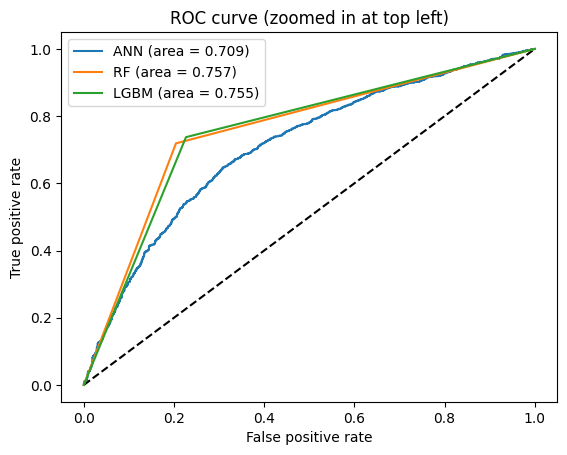

In [7]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ann, tpr_ann, label='ANN (area = {:.3f})'.format(auc_ann))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (area = {:.3f})'.format(auc_lgbm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Guardar los modelos en un archivo

In [ ]:
# save
joblib.dump(rfc, "rfc.joblib")
model.save("ann.h5")

In [52]:
# lightgbm_cf.booster_.save_model('lgbm_cf.txt')
joblib.dump(lightgbm_cf, 'lgbm_cf.pkl')

['lgbm_cf.pkl']